In [ ]:
%tensorflow_version 1.x
import tensorflow
import keras
import sys

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
!pip3 install scikit-image
!pip3 install opencv-python

import skimage
print(skimage.__version__)
print(tensorflow.__version__)
print(keras.__version__)


0.16.2
1.15.2
2.3.1


In [ ]:
!git clone https://github.com/tejalbarnwal/Mask-RCNN-TF2.git

fatal: destination path 'Mask-RCNN-TF2' already exists and is not an empty directory.


In [ ]:
cd /content/Mask-RCNN-TF2/carla

/content/Mask-RCNN-TF2/carla


In [ ]:
import xml 
im_name = "Town01_001920"
with open("/content/Mask-RCNN-TF2/carla/train/xml/"+ im_name + ".xml") as f:
  print(f.read())

<annotation>
	<folder>_rgb</folder>
	<filename>Town01_001920.png</filename>
	<path>/home/daniel/CARLA_0.9.5/PythonAPI/examples/Dataset/Town01_40_vehicles/_rgb/001920.png</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>640</width>
		<height>380</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>vehicle</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>308</xmin>
			<ymin>193</ymin>
			<xmax>339</xmax>
			<ymax>219</ymax>
		</bndbox>
	</object>
	<object>
		<name>vehicle</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>227</xmin>
			<ymin>190</ymin>
			<xmax>269</xmax>
			<ymax>221</ymax>
		</bndbox>
	</object>
	<object>
		<name>vehicle</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>266</xmin>
			<ymin>190</ymin>
			<xmax>288</xmax>
			<ymax>210</ymax>
		</

In [ ]:
import skimage.io
import matplotlib.pyplot, matplotlib.patches

def extract_boxes(filename):
  tree = xml.etree.ElementTree.parse(filename)

  root = tree.getroot()

  boxes = list()

  for object1 in root.findall("./object"):
    name = str(object1.find("name").text)
    print("TEJU", name)
    xmin = int(object1.find("bndbox/xmin").text)
    ymin = int(object1.find("bndbox/ymin").text)
    xmax = int(object1.find("bndbox/xmax").text)
    ymax = int(object1.find("bndbox/ymax").text)

    coors = [xmin , ymin , xmax , ymax]
    print(coors)
    boxes.append(coors)
  return boxes

TEJU vehicle
[308, 193, 339, 219]
TEJU vehicle
[227, 190, 269, 221]
TEJU vehicle
[266, 190, 288, 210]
there are 3 objects in the image
bboxes: [[308, 193, 339, 219], [227, 190, 269, 221], [266, 190, 288, 210]]



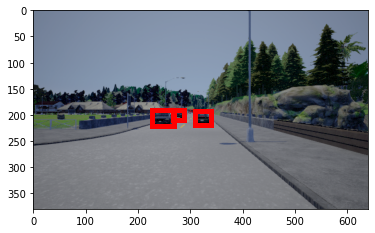

In [ ]:
im_name = "Town01_001920"

img = skimage.io.imread("/content/Mask-RCNN-TF2/carla/train/png/" + im_name + ".png")

boxes = extract_boxes("/content/Mask-RCNN-TF2/carla/train/xml/"+im_name+".xml")
print("there are {count} objects in the image".format(count=len(boxes)))
print("bboxes:", boxes, end="\n\n")

fig, ax = matplotlib.pyplot.subplots()
ax.imshow(img)

for box_idx in range(len(boxes)):
  rect = matplotlib.patches.Rectangle( (boxes[box_idx][0], boxes[box_idx][1]),
                                       boxes[box_idx][2]-boxes[box_idx][0], boxes[box_idx][3]-boxes[box_idx][1],
                                       linewidth = 5, edgecolor="r", facecolor="none")
  
  ax.add_patch(rect)


matplotlib.pyplot.show()

In [ ]:
cd /content/Mask-RCNN-TF2/

/content/Mask-RCNN-TF2


In [ ]:
pwd

'/content/Mask-RCNN-TF2'

In [ ]:
import os
train_dataset_dir = "/content/Mask-RCNN-TF2/carla/train/"
for filename in os.listdir(train_dataset_dir):
  image_id = filename[:-4]

In [ ]:
# preparing the dataset

import os
import xml.etree
from numpy import zeros, asarray

import mrcnn.utils
import mrcnn.config
import mrcnn.model

class tejuDataset(mrcnn.utils.Dataset):
  def load_dataset(self, dataset_dir):

    self.add_class("dataset",1,"vehicle")
    self.add_class("dataset",2,"bike")
    self.add_class("dataset",3,"motobike")
    self.add_class("dataset",4,"traffic_light")
    self.add_class("dataset",5,"traffic_sign")

    images_dir = dataset_dir + '/png/'
    annotations_dir = dataset_dir + '/xml/'
    
    for filename in os.listdir(images_dir):
      image_id = filename[:-4]

      img_path = images_dir + filename
      ann_path = annotations_dir + image_id + '.xml'

      self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

  def load_mask(self, image_id):
    info = self.image_info[image_id]
    path = info["annotation"]
    boxes, w, h , classes = self.extract_boxes(path)
    masks = zeros([h, w, len(boxes)], dtype='uint8')

    class_ids = list()
    for i in range(len(boxes)):
        box = boxes[i]
        row_s, row_e = box[1], box[3]
        col_s, col_e = box[0], box[2]
        masks[row_s:row_e, col_s:col_e, i] = 1
        class_ids.append(self.class_names.index(classes[i]))
    return masks, asarray(class_ids, dtype='int32')

  def extract_boxes(self, filename):
        tree = xml.etree.ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        classes = list()
       
        for object1 in root.findall("./object"):
          name = str(object1.find("name").text)
          classes.append(name)
          # print("TEJU", name)
          xmin = int(object1.find("bndbox/xmin").text)
          ymin = int(object1.find("bndbox/ymin").text)
          xmax = int(object1.find("bndbox/xmax").text)
          ymax = int(object1.find("bndbox/ymax").text)
          coors = [xmin, ymin, xmax, ymax]
          boxes.append(coors)


        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height , classes

In [ ]:
train_dataset = tejuDataset()
train_dataset.load_dataset(dataset_dir='/content/Mask-RCNN-TF2/carla/train')
train_dataset.prepare()

validation_dataset = tejuDataset()
validation_dataset.load_dataset(dataset_dir='/content/Mask-RCNN-TF2/carla/val')
validation_dataset.prepare()

In [ ]:
class tejuConfig(mrcnn.config.Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "dataset_cfg"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 5  # Background + toy

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [ ]:
teju_config = tejuConfig()

In [ ]:
model = mrcnn.model.MaskRCNN(mode='training', 
                             model_dir='./log', 
                             config=teju_config)


model.keras_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead
Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
______________________________________

In [ ]:
import urllib.request

urllib.request.urlretrieve("https://github.com/matterport/Mask_RCNN/releases/download/v1.0/mask_rcnn_coco.h5","mask_rcnn_coco.h5" )
# urllib.request.urlretrieve("https://drive.google.com/file/d/10ZEn-d-9WKnuaHDTA6-ISQ7bzEmhhBwv/view?usp=sharing","teju_mask_rcnn_trained.h5")

('mask_rcnn_coco.h5', <http.client.HTTPMessage at 0x7fbb1f567c90>)

In [ ]:
!pip3 install h5py==2.10.0 --force-reinstall

  Using cached https://files.pythonhosted.org/packages/3f/c0/abde58b837e066bca19a3f7332d9d0493521d7dd6b48248451a9e3fe2214/h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/3f/03/c3526fb4e79a793498829ca570f2f868204ad9a8040afcd72d82a8f121db/numpy-1.21.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d9/5a/e7c31adbe875f2abbb91bd84cf2dc52d792b5a01506781dbcf25c91daf11/six-1.16.0-py2.py3-none-any.whl
ERROR: lucid 0.3.10 requires umap-learn, which is not installed.
ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.4.0 which is incompatible.
ERROR: lucid 0.3.10 has requirement numpy<=1.19, but you'll have numpy 1.21.0 which is incompatible.
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.


In [ ]:
model.load_weights(filepath='mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
print("weights loaded")


model.train(train_dataset=train_dataset, 
            val_dataset=validation_dataset ,
            learning_rate=teju_config.LEARNING_RATE, 
            epochs=10, 
            layers='heads',
            )

model_path = 'teju_mask_rcnn_trained.h5'
model.keras_model.save_weights(model_path)

weights loaded

Starting at epoch 0. LR=0.001

Checkpoint Path: //logdir//train/mask_rcnn_dataset_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4       

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-1.15.2/python3.7/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
100/100 [==============================] - 101s 1s/step - loss: 2.1939 - val_loss: 1.3223

Epoch 2/10
100/100 [==============================] - 62s 623ms/step - loss: 1.4585 - val_loss: 1.9909
Epoch 3/10
100/100 [==============================] - 62s 620ms/step - loss: 1.2462 - val_loss: 1.1917
Epoch 4/10
100/100 [==============================] - 62s 623ms/step - loss: 1.1243 - val_loss: 2.1670
Epoch 5/10
100/100 [==============================] - 62s 624ms/step - loss: 0.9974 - val_loss: 1.4114
Epoch 6/10
100/100 [==============================] - 62s 624ms/step - loss: 0.8513 - val_loss: 1.2705
Epoch 7/10
100/100 [==============================] - 62s 625ms/step - loss: 0.9936 - val_loss: 0.3282
Epoch 8/10
100/100 [==============================] - 63s 626ms/step - loss: 0.9879 - val_loss: 1.8120
Epoch 9/10
100/100 [==============================] - 62s 624ms/step - loss: 1.0505 - val_loss: 1.0669
Epoch 10/10
100/100 [==============================] - 62s 622ms/step - lo

In [ ]:
cd /content/Mask-RCNN-TF2/

/content/Mask-RCNN-TF2


In [ ]:
pwd

'/content/Mask-RCNN-TF2'

In [ ]:
import cv2
import mrcnn.config
import mrcnn.model

CLASS_NAMES = ['BG', 'vehicle',"bike","motobike","traffic_light","traffic_sign"]

class SimpleConfig(mrcnn.config.Config):
    # Give the configuration a recognizable name
    NAME = "coco_inference"
    
    # set the number of GPUs to use along with the number of images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

	# Number of classes = number of classes + 1 (+1 for the background). The background class is named BG
    NUM_CLASSES = len(CLASS_NAMES)

# Initialize the Mask R-CNN model for inference and then load the weights.
# This step builds the Keras model architecture.
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

# Load the weights into the model.
model.load_weights(filepath="teju_mask_rcnn_trained.h5", 
                   by_name=True)


# Visualize the detected objects.
# from mrcnn import visualize
# visualize.display_instances(image=image, 
#                                   boxes=r['rois'], 
#                                   masks=r['masks'], 
#                                   class_ids=r['class_ids'], 
#                                   class_names=CLASS_NAMES, 
#                                   scores=r['scores'])


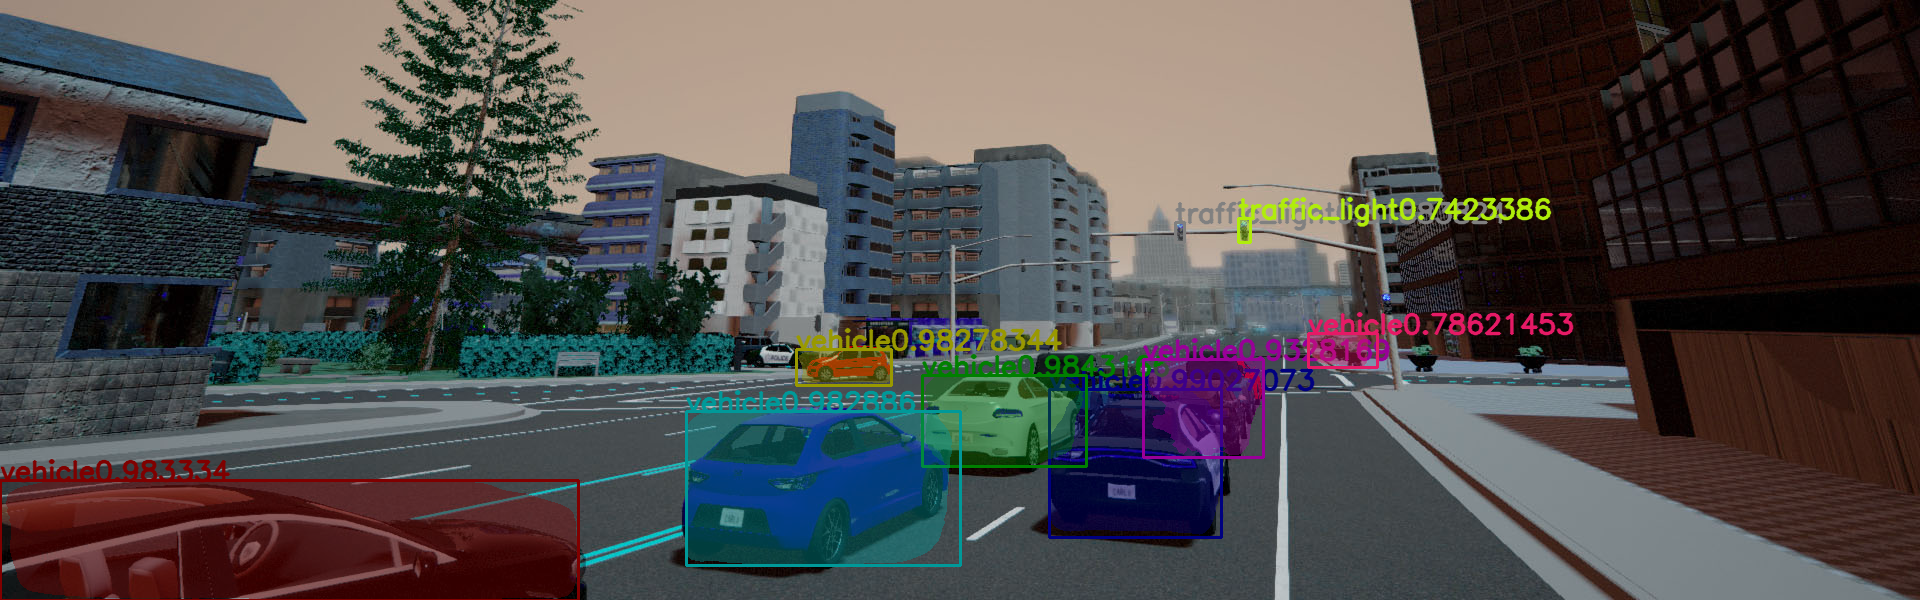

In [ ]:
import cv2
import time
import numpy as np
from google.colab.patches import cv2_imshow
# load the input image, convert it from BGR to RGB channel
image = cv2.imread("/content/c2.jpg")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform a forward pass of the network to obtain the results
r = model.detect([image], verbose=0)

# Get the results for the first image.
r = r[0]
boxes = r["rois"]
masks = r["masks"]
classes = r["class_ids"]
scores = r["scores"]
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.9
color = (0, 255, 0)
thickness = 2
######
colors = [
          [0.5,0,0],
          [0,0.5,0],
          [0,0,0.5],
          [0.6,0.6,0],
          [0,0.6,0.6],
          [0.6,0,0.6],
          [0.5,0.5,0.5],
          [0.4,0.1,0.9],
          [0.04,0.93,0.69],
          [0.12,0.58,1],
          [1,0.96,0.12],
          [0.93,0.05,0.78],
          [0.6,0.49,0.79],
          [0.09,0.09,0.22],
          [0.1,0.2,0.05],
          [0.02,0.03,0.02],
          [0.97,1,0.98]

]
x1 = 0.0
y1 = 0.0
x2 = 0.0
y2 = 0.0
img = image
for i in range(len(boxes)):
    x = boxes[i][0]
    y = boxes[i][1]
    w = boxes[i][2]
    h = boxes[i][3]
    cv2.rectangle(img, (y,x), (h,w), np.array(colors[i])* 255 , 2)
    x1 = x
    y1 = y
    w1 = w
    h1 = h
    # org = (-10+(h+y)//2, -10+(w+x)//2)
    org = (y,x)
    # print(classes[i])
    cv2.putText(img,CLASS_NAMES[classes[i]] + str(scores[i]), org, font,fontScale, np.array(colors[i])* 255, thickness, cv2.LINE_AA)
    alpha = 0.4
    for c in range(3):
      # print(img.shape)
      img[:, :, c] = np.where(masks[:,:,i] == 1,
                                image[:, :, c] * (1 - alpha) + alpha * colors[i][c] * 255,
                                image[:, :, c])

cv2_imshow(img)

# time.sleep(5)
# if cv2.waitKey(1) & 0xFF == ord('q'):
    

In [ ]:
np.array(colors[1]) * 255

array([  0. , 127.5,   0. ])

In [ ]:
import cv2
import time

from google.colab.patches import cv2_imshow
n=1
cap = cv2.VideoCapture("/content/output1.mp4"); 
fourcc = cv2.VideoWriter_fourcc(*'XVID');   #or fourcc = cv2.VideoWriter_fourcc('X','V','I','D');
out = cv2.VideoWriter('teju.avi',fourcc,20.0,(640,480));   


while(cap.isOpened()):             

    ret, frame = cap.read() 
    if ret == True:
        print(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   #different values of propId. It gives width of the frame
        print(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))   #It gives height of the frame
        
        #out.write(frame)    #out is the instance of video writer and we pass frame which we captured 
        
        r = model.detect([frame], verbose=0)

        # Get the results for the first image.
        r = r[0]
        boxes = r["rois"]
        masks = r["masks"]
        classes = r["class_ids"]
        scores = r["scores"]
        img = frame
        for i in range(len(boxes)):
            x = boxes[i][0]
            y = boxes[i][1]
            w = boxes[i][2]
            h = boxes[i][3]
            cv2.rectangle(img, (y,x), (h,w), np.array(colors[i])* 255 , 2)
            org = (y,x)
            # print(classes[i])
            cv2.putText(img,CLASS_NAMES[classes[i]] + str(scores[i]), org, font,fontScale, np.array(colors[i])* 255, thickness, cv2.LINE_AA)
            alpha = 0.4
            for c in range(3):
              # print(img.shape)
              img[:, :, c] = np.where(masks[:,:,i] == 1,
                                        img[:, :, c] * (1 - alpha) + alpha * colors[i][c] * 255,
                                        img[:, :, c])
        
        out.write(img)
        print(n)
        n = n+1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        print("wtf")
        break

cap.release()
out.release()   #release all the resources
cv2.destroyAllWindows() 

640.0
480.0
1
640.0
480.0
2
640.0
480.0
3
640.0
480.0
4
640.0
480.0
5
640.0
480.0
6
640.0
480.0
7
640.0
480.0
8
640.0
480.0
9
640.0
480.0
10
640.0
480.0
11
640.0
480.0
12
640.0
480.0
13
640.0
480.0
14
640.0
480.0
15
640.0
480.0
16
640.0
480.0
17
640.0
480.0
18
640.0
480.0
19
640.0
480.0
20
640.0
480.0
21
640.0
480.0
22
640.0
480.0
23
640.0
480.0
24
640.0
480.0
25
640.0
480.0
26
640.0
480.0
27
640.0
480.0
28
640.0
480.0
29
640.0
480.0
30
640.0
480.0
31
640.0
480.0
32
640.0
480.0
33
640.0
480.0
34
640.0
480.0
35
640.0
480.0
36
640.0
480.0
37
640.0
480.0
38
640.0
480.0
39
640.0
480.0
40
640.0
480.0
41
640.0
480.0
42
640.0
480.0
43
640.0
480.0
44
640.0
480.0
45
640.0
480.0
46
640.0
480.0
47
640.0
480.0
48
640.0
480.0
49
640.0
480.0
50
640.0
480.0
51
640.0
480.0
52
640.0
480.0
53
640.0
480.0
54
640.0
480.0
55
640.0
480.0
56
640.0
480.0
57
640.0
480.0
58
640.0
480.0
59
640.0
480.0
60
640.0
480.0
61
640.0
480.0
62
640.0
480.0
63
640.0
480.0
64
640.0
480.0
65
640.0
480.0
66
640.0
480.0
67
640.